Building Sierpinski graph with DEPTH=5 (this can grow fast)...

Nodes: 366, Edges: 729

Adjacency Matrix:
 [[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]

Degree Matrix:
 [[2 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 2]]

Laplacian Matrix:
 [[ 2. -1. -1. ...  0.  0.  0.]
 [-1.  4. -1. ...  0.  0.  0.]
 [-1. -1.  4. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4. -1. -1.]
 [ 0.  0.  0. ... -1.  4. -1.]
 [ 0.  0.  0. ... -1. -1.  2.]]

Signless Laplacian Matrix:
 [[2. 1. 1. ... 0. 0. 0.]
 [1. 4. 1. ... 0. 0. 0.]
 [1. 1. 4. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 4. 1. 1.]
 [0. 0. 0. ... 1. 4. 1.]
 [0. 0. 0. ... 1. 1. 2.]]

Adjacency Eigenvalues (unsorted):
 [ 3.99702481+0.00000000e+00j  3.98907578+0.00000000e+00j
  3.96461652+0.00000000e+00j  3.95463653+0.00000000e+00j
  3.94477892+0.00000000e+00j  3.71687628+0.00000000e+

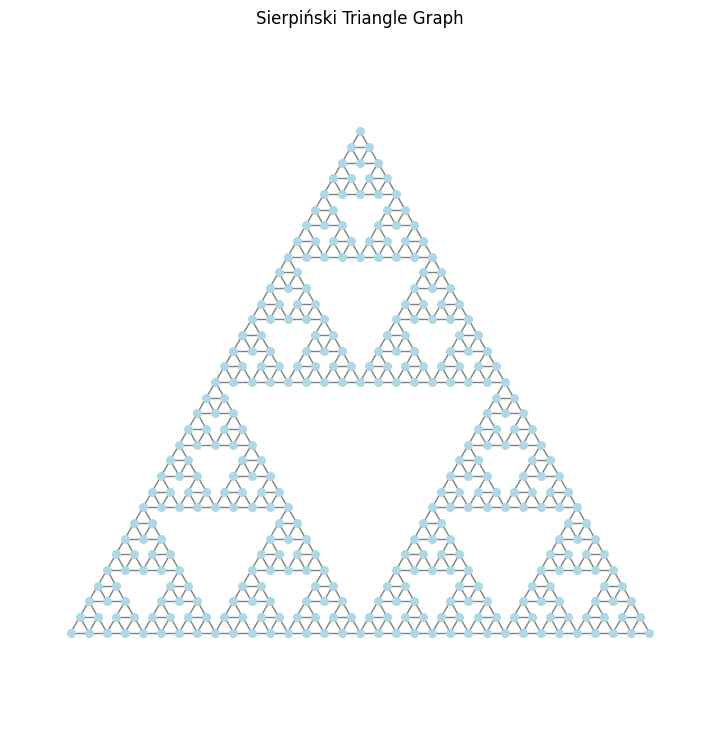

In [1]:
# Following is the Python code for the Sierpinski Graph with various matrices

import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sympy import Matrix

# ------------------------------
# 1. Build Sierpinski Graph
# ------------------------------
def midpoint(a, b):
    return ((a[0] + b[0]) / 2.0, (a[1] + b[1]) / 2.0)

def collect_leaf_triangles(vertices, depth, out):
    """Recursively collect leaf triangles."""
    if depth == 0:
        out.append(tuple(vertices))
        return
    A, B, C = vertices
    AB = midpoint(A, B)
    BC = midpoint(B, C)
    CA = midpoint(C, A)
    collect_leaf_triangles((A, AB, CA), depth - 1, out)
    collect_leaf_triangles((AB, B, BC), depth - 1, out)
    collect_leaf_triangles((CA, BC, C), depth - 1, out)

def build_sierpinski_graph(depth):
    A = (0.0, 0.0)
    B = (1.0, 0.0)
    H = math.sqrt(3) / 2.0
    C = (0.5, H)

    leaves = []
    collect_leaf_triangles((A, B, C), depth, leaves)

    def key(pt):
        return (round(pt[0], 10), round(pt[1], 10))

    pts_index, index_pts, idx, edges = {}, {}, 0, set()

    for tri in leaves:
        for i in range(3):
            p1 = key(tri[i])
            p2 = key(tri[(i + 1) % 3])
            if p1 not in pts_index:
                pts_index[p1] = idx
                index_pts[idx] = p1
                idx += 1
            if p2 not in pts_index:
                pts_index[p2] = idx
                index_pts[idx] = p2
                idx += 1
            edges.add(tuple(sorted((pts_index[p1], pts_index[p2]))))

    G = nx.Graph()
    for i, coord in index_pts.items():
        G.add_node(i, pos=coord)
    G.add_edges_from(list(edges))
    return G

# ------------------------------
# 2. Compute matrices and properties (including ABC)
# ------------------------------
def compute_all_properties(G):
    A = nx.to_numpy_array(G, dtype=float)    # adjacency
    n = A.shape[0]
    degrees_list = [d for _, d in G.degree()]
    D = np.diag(degrees_list)
    L = D - A
    Q = D + A

    # ---- BASIC PRINTS ----
    print(f"\nNodes: {n}, Edges: {G.number_of_edges()}")
    print("\nAdjacency Matrix:\n", A)
    print("\nDegree Matrix:\n", D)
    print("\nLaplacian Matrix:\n", L)
    print("\nSignless Laplacian Matrix:\n", Q)

    # ---- Eigenvalues & Energies ----
    def spectral_energy(M, name):
        eigvals = np.linalg.eigvals(M)
        energy = np.sum(np.abs(eigvals))
        sorted_eigs = np.sort(eigvals)[::-1]
        print(f"\n{name} Eigenvalues (unsorted):\n", eigvals)
        print(f"\n{name} Sorted Eigenvalues (top 3):\n", sorted_eigs[:3])
        print(f"\n{name} Energy: {energy}")
        return eigvals, sorted_eigs, energy

    eigA, sortedA, energyA = spectral_energy(A, "Adjacency")
    eigL, sortedL, energyL = spectral_energy(L, "Laplacian")
    eigQ, sortedQ, energyQ = spectral_energy(Q, "Signless Laplacian")

    # ---- Distance matrix ----
    dist_matrix = np.array(nx.floyd_warshall_numpy(G, nodelist=sorted(G.nodes())), dtype=float)
    print("\nDistance Matrix:\n", dist_matrix)
    eigD, sortedD, energyD = spectral_energy(dist_matrix, "Distance")

    # ---- Seidel matrix ----
    seidel = np.where(A == 1, -1.0, 1.0)
    np.fill_diagonal(seidel, 0.0)
    print("\nSeidel Matrix:\n", seidel)
    eigS, sortedS, energyS = spectral_energy(seidel, "Seidel")

    # ---- Arithmetic-Geometric matrix ----
    AG = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if A[i, j] == 1.0:
                di = degrees_list[i]
                dj = degrees_list[j]
                if di > 0 and dj > 0:
                    AG[i, j] = (di + dj) / (2.0 * math.sqrt(di * dj))
                else:
                    AG[i, j] = 0.0
    print("\nArithmetic-Geometric Matrix:\n", AG)
    eigAG, sortedAG, energyAG = spectral_energy(AG, "Arithmetic-Geometric")

    # ---- Zagreb matrices ----
    Z1 = np.zeros((n, n), dtype=float)
    Z2 = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if A[i, j] == 1.0:
                Z1[i, j] = degrees_list[i] + degrees_list[j]
                Z2[i, j] = degrees_list[i] * degrees_list[j]
    print("\nFirst Zagreb Matrix:\n", Z1)
    eigZ1, sortedZ1, energyZ1 = spectral_energy(Z1, "First Zagreb")
    print("\nSecond Zagreb Matrix:\n", Z2)
    eigZ2, sortedZ2, energyZ2 = spectral_energy(Z2, "Second Zagreb")

    # ---- ABC matrix ----
    ABC = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if A[i, j] == 1.0:
                di = degrees_list[i]
                dj = degrees_list[j]
                # guard against division by zero
                if di > 0 and dj > 0:
                    val = (di + dj - 2.0) / (di * dj)
                    # sometimes rounding can produce tiny negative values; clamp
                    val = max(val, 0.0)
                    ABC[i, j] = math.sqrt(val)
                else:
                    ABC[i, j] = 0.0
    print("\nAtom-Bond Connectivity (ABC) Matrix:\n", ABC)
    # spectral info for ABC
    eigABC, sortedABC, energyABC = spectral_energy(ABC, "ABC (Atom-Bond Connectivity)")

    # Summary of all energies
    print("\n--- ENERGY SUMMARY ---")
    print(f"Adjacency Energy: {energyA}")
    print(f"Laplacian Energy: {energyL}")
    print(f"Signless Laplacian Energy: {energyQ}")
    print(f"Distance Energy: {energyD}")
    print(f"Seidel Energy: {energyS}")
    print(f"Arithmetic-Geometric Energy: {energyAG}")
    print(f"First Zagreb Energy: {energyZ1}")
    print(f"Second Zagreb Energy: {energyZ2}")
    print(f"ABC Energy: {energyABC}")

    # Optionally return matrices
    return {
        "A": A, "D": D, "L": L, "Q": Q, "Distance": dist_matrix,
        "Seidel": seidel, "AG": AG, "Z1": Z1, "Z2": Z2, "ABC": ABC
    }

# ------------------------------
# 3. Visualization
# ------------------------------
def draw_graph(G):
    pos = nx.get_node_attributes(G, "pos")
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos, node_size=30, edge_color="gray", node_color="lightblue")
    plt.axis("equal")
    plt.axis("off")
    plt.title("Sierpiński Triangle Graph")
    plt.show()

# ------------------------------
# MAIN
# ------------------------------
if __name__ == "__main__":
    DEPTH = 5   # safe default; increase carefully (DEPTH=6 may be large)
    print(f"Building Sierpinski graph with DEPTH={DEPTH} (this can grow fast)...")
    G = build_sierpinski_graph(DEPTH)
    matrices = compute_all_properties(G)
    draw_graph(G)
